In [278]:
# Clustering Test File for R3 Muon RoI Trigger Work

# Coders: Nathan Suri, Caltech
# Date: August 26, 2019
# LPC LLP Group

# Description
# Determine optimal clustering scheme for identifying LLP clusters

# Action Plan
# Look at DBSCAN and other algorithms
# Run second moment calculations

# Notes/Conclusions
# @nasurijr:

In [279]:
# User specifics
# Setups pwd location for data files and imports of special ROOT utilities

work_location = input("Username: ")
if work_location == 'nasurijr':
    pwd = '/nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/'
    
    # Sets display width
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:85% !important; }</style>"))
    
# elif work_location == '<Insert Tier2 username here>':
#     pwd = '/home/cms/delayed_jet_analyzer/'

Username: nasurijr


# Imports

In [280]:
# Imports necessary utilities and modules

import ROOT as rt
import root_numpy as rtnp
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

# Graph/histo utilities from ROOT
# Contained within the delayed_jet_analyzer repository
import sys
sys.path.append(pwd+'lib')
from histo_utilities import create_TH1D, create_TH2D, create_TGraph, std_color_list

# Used for extracting the TTree structure from each datafile
import os
import uproot

# Used for creating user-readable tables
from prettytable import PrettyTable

# Imports jet clustering algorithm (FastJet)
from pyjet import cluster

# Imports scikit-learn
import sklearn.cluster as skc
import sklearn.datasets as skd
import sklearn.preprocessing as skp
from sklearn.neighbors.nearest_centroid import NearestCentroid


donotdelete = []

# Read in and Extract TTrees from Datafiles

In [476]:
# Setups dictionaries for storing data from MC/data ntuples
fpath = {}
tree = {}

data_path = pwd+'data/'

# Background Samples
fpath['qcd'] = data_path +'jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8_1.root'

fpath['wjetstolnu'] = data_path + 'WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root'

################################################################

# ggH Signal Samples
# mH = 125 GeV, mX = 50 GeV, ctau = 1 m
fpath['m50ct1000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl1000_ev100000.root'

# mH = 125 GeV, mX = 50 GeV, ctau = 10 m
fpath['m50ct10000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl10000_ev100000.root'

# mH = 2000 GeV, mX = 975 GeV, ctau = 1 m
fpath['m975ct1000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl1000_ev100000.root'

# mH = 2000 GeV, mX = 975 GeV, ctau = 10 m
fpath['m975ct10000mm'] = data_path+'jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl10000_ev100000.root'

# WH Signal Samples
# mH = 125 GeV, mX = 55 GeV, ctau = 10 m
fpath['wh_m55ct10m']  = data_path+'WH_HToSSTobbbb_WToLNu_MH-125_MS-55_ctauS-10000_TuneCUETP8M1_13TeV-powheg-pythia8_1pb_weighted.root'


# Iterates through each file and extracts the ROOT TTree structure from each
for k,v in fpath.items():
    print(str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
    print(k, v)
    root_dir = uproot.open(v)
    if k[0] == 'w':
        tree[k] = root_dir['MuonSystem']
    else:
        tree[k] = root_dir['ntuples']['llp']

2019-08-30 12:06:21.787933-07:00
qcd /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/jet_timing_studies_ntuple_RunIIFall17DRPremix_QCD_Pt_170to300_TuneCP5_13TeV_pythia8_1.root
2019-08-30 12:06:22.345133-07:00
wjetstolnu /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8_1pb_weighted.root
2019-08-30 12:06:22.645271-07:00
m50ct1000mm /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl1000_ev100000.root
2019-08-30 12:06:23.203566-07:00
m50ct10000mm /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/jet_timing_studies_ntuple_metbb_ggh_ISR_mh125_mx50_pl10000_ev100000.root
2019-08-30 12:06:23.886762-07:00
m975ct1000mm /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/jet_timing_studies_ntuple_metbb_ggh_ISR_mh2000_mx975_pl1000_ev100000.root
2019-08-30 12:06:24.414371-07:00
m975ct10000mm /nfshome/nasurijr/LLP_analysis/delayed_jet_analyzer/data/jet_timing_stu

## Name TTree Objects

In [477]:
# Bookkeeping: Defines the TTrees from the read datafiles
# Names displayed in README.md table

T = tree['m50ct1000mm']
T_bkg = tree['qcd']
# T_minBias = tree['zeroBias']
T_low_ctau10 = tree['m50ct10000mm']
T_high_ctau1 = tree['m975ct1000mm']
T_high_ctau10 = tree['m975ct10000mm']
T_wh = tree['wh_m55ct10m']
T_wjetstolnu = tree['wjetstolnu']

# Define Variables and Name Datafiles

In [478]:
# Variable Definitions
# Creates dictionaries for variables to be analyzed
# The dictionaries will contain the variable arrays for each datafile with a relevant key

# Boolean selections
sel_bool = {}

# CSC
nCsc = {}
csc_z = {}
csc_x = {}
csc_y = {}
csc_eta = {}
csc_phi = {}
csc_t = {}
csc_r = {}

# Gen Level
gLLP_eta = {}
gLLP_phi = {}
gLLP_r_0 = {}
gLLP_r_1 = {}
gLLP_decay_0 = {}
gLLP_decay_1 = {}

# Reco level
met_pt = {}
eventNum = {}
lumiNum = {}
jet_pt = {}
ele_pt = {}
mu_pt = {}
nJets = {}
nElectrons = {}
nMuons = {}
nRechits_flag = {}

# Reco - jets
jetEta = {}
jetPhi = {}

In [479]:
# Bookkeeping: Creates a dictionary for iterating over all of the datafiles and 
#              converting the relevant branches to numpy arrays
# Names displayed in README.md table

# data_trees = {'m50ct1m': T, 'qcd': T_bkg, 'zeroBias':T_minBias, 'm50ct10m': T_low_ctau10, 'm975ct1m': T_high_ctau1, 'm975ct10m': T_high_ctau10}
data_trees = {'m50ct1m': T, 'qcd': T_bkg, 'm50ct10m': T_low_ctau10, 'm975ct1m': T_high_ctau1, 'm975ct10m': T_high_ctau10, 'wh_m55ct10m': T_wh, 'wjetstolnu': T_wjetstolnu}

# Event Selection

## TBranch -> np.array() Conversion

In [480]:
# Event Selection

print('Start: ' + str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

for species, arbor in data_trees.items():
#     if 'wh' in species:
#         ele_sel = np.logical_and(np.logical_and(np.absolute(arbor['gParticleId'].array()) == 13, np.absolute(arbor['gParticleMotherId'].array()) == 24), arbor['gParticleStatus'].array() == 1)
#         mu_sel = np.logical_and(np.logical_and(np.absolute(arbor['gParticleId'].array()) == 11, np.absolute(arbor['gParticleMotherId'].array()) == 24), arbor['gParticleStatus'].array() == 1)
#         sel_lepton = []
#         time_counter = 0
        
#         # To look at both muon/electron channels
# #         for ev in np.logical_or(ele_sel, mu_sel):
#         # For electron-only channel
# #         for ev in ele_sel:
# #             time_counter += 1
# #             if (time_counter % 100000) == 0:
# #                 print(str(time_counter) + ': '+  str(datetime.datetime.now(pytz.timezone('US/Pacific'))))
# #             if ev.any():
# #                 sel_lepton.append(True)
# #             else:
# #                 sel_lepton.append(False)
                
#     if 'wh' not in species:
#         sel_lepton = np.ones(len(arbor), dtype=bool)
                
    if 'metbb' in species or 'bbmet' in species:
        gLLP_r_0[species] = np.sqrt((arbor['gLLP_decay_vertex_x'].array()[:,0])**2+(arbor['gLLP_decay_vertex_y'].array()[:,0])**2)
        gLLP_decay_0[species] = np.sqrt((arbor['gLLP_decay_vertex_x'].array()[:,0])**2+(arbor['gLLP_decay_vertex_y'].array()[:,0])**2 + (arbor['gLLP_decay_vertex_z'].array()[:,0])**2)

        sel_dis_0 = np.logical_and(np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) > 568 , np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) < 1100)
        sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(arbor['gLLP_eta'].array()[:,0])<2.4)
        sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(arbor['gLLP_eta'].array()[:,0])>0.9)
        sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(gLLP_r_0[species])<695.5)
        
        sel_signal = np.logical_and(sel_dis_1, sel_lepton)
        sel_bool[species] = sel_signal 
        
    if 'bbbb' in species:
        gLLP_r_0[species] = np.sqrt((arbor['gLLP_decay_vertex_x'].array()[:,0])**2+(arbor['gLLP_decay_vertex_y'].array()[:,0])**2)
        gLLP_r_1[species] = np.sqrt((arbor['gLLP_decay_vertex_x'].array()[:,1])**2+(arbor['gLLP_decay_vertex_y'].array()[:,1])**2)

        
        sel_dis_0 = np.logical_and(np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) > 568 , np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,0]) < 1100)
        sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(arbor['gLLP_eta'].array()[:,0])<2.4)
        sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(arbor['gLLP_eta'].array()[:,0])>0.9)
        sel_dis_0 = np.logical_and(sel_dis_0, np.absolute(gLLP_r_0[species])<695.5)
        
        sel_dis_1 = np.logical_and(np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,1]) > 568 , np.absolute(arbor['gLLP_decay_vertex_z'].array()[:,1]) < 1100)
        sel_dis_1 = np.logical_and(sel_dis_1, np.absolute(arbor['gLLP_eta'].array()[:,1])<2.4)
        sel_dis_1 = np.logical_and(sel_dis_1, np.absolute(arbor['gLLP_eta'].array()[:,1])>0.9)
        sel_dis_1 = np.logical_and(sel_dis_1, np.absolute(gLLP_r_1[species])<695.5)
        
        sel_signal = np.logical_or(sel_dis_0, sel_dis_1)
        sel_bool[species] = sel_signal 
        
    else:
        sel_bool[species] = np.ones(len(arbor['nCsc'].array()), dtype=bool)
        
    print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

Start: 2019-08-30 12:11:50.798469-07:00
m50ct1m: 2019-08-30 12:11:50.980030-07:00
qcd: 2019-08-30 12:11:51.252689-07:00
m50ct10m: 2019-08-30 12:11:51.398186-07:00
m975ct1m: 2019-08-30 12:11:51.485222-07:00
m975ct10m: 2019-08-30 12:11:51.563820-07:00
wh_m55ct10m: 2019-08-30 12:11:51.565365-07:00
wjetstolnu: 2019-08-30 12:11:51.625315-07:00


In [483]:
# Application of event selection to variables

print('Start: ' + str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

# csc_r_quad = {}
for species, arbor in data_trees.items():
    # Endcap: CSCs
    nCsc[species] = arbor['nCsc'].array()#[sel_bool[species]]
    csc_z[species] = arbor['cscZ'].array()#[sel_bool[species]]
    csc_x[species] = arbor['cscX'].array()#[sel_bool[species]]
    csc_y[species] = arbor['cscY'].array()#[sel_bool[species]]
    csc_t[species] = arbor['cscT'].array()#[sel_bool[species]]
    csc_eta[species] = arbor['cscEta'].array()#[sel_bool[species]]
    csc_phi[species] = arbor['cscPhi'].array()#[sel_bool[species]]
#     csc_r_quad[species] = np.array(arbor['cscX'].array()[sel_bool[species]])**2 + np.array(arbor['cscY'].array()[sel_bool[species]])**2
#     csc_r[species] = []
#     for hit_r in csc_r_quad[species]:
#         r_val = np.sqrt(hit_r.astype(float))
#         csc_r[species].append(r_val)

    # Reco-level
    if species[0] == 'w':
        eventNum[species] = arbor['evtNum'].array()#[sel_bool[species]]
        lumiNum[species] = arbor['lumiSec'].array()#[sel_bool[species]]
    else:
        eventNum[species] = arbor['eventNum'].array()#[sel_bool[species]]
        lumiNum[species] = arbor['lumiNum'].array()#[sel_bool[species]]
#     met_pt[species] = arbor['metType1Pt'].array()[sel_bool[species]]
    
    jet_pt[species] = arbor['jetPt'].array()#[sel_bool[species]]
#     ele_pt[species] = arbor['elePt'].array()[sel_bool[species]]
#     mu_pt[species] = arbor['muonPt'].array()[sel_bool[species]]
    nJets[species] = arbor['nJets'].array()#[sel_bool[species]]
#     nElectrons[species] = arbor['nElectrons'].array()[sel_bool[species]]
#     nMuons[species] = arbor['nMuons'].array()[sel_bool[species]]
#     if species not in ('ggH', 'zeroBias', 'qcd'):
#     nRechits_flag[species] = (arbor['cscNRecHits_flag'].array())[sel_bool[species]]
#     gLLP_eta[species] = arbor['gLLP_eta'].array()[sel_bool[species]]
#     gLLP_phi[species] = arbor['gLLP_phi'].array()[sel_bool[species]]

    
    
    jetEta[species] = arbor['jetEta'].array()[sel_bool[species]]
    jetPhi[species] = arbor['jetPhi'].array()[sel_bool[species]]
    
    print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

Start: 2019-08-30 12:14:14.902020-07:00
m50ct1m: 2019-08-30 12:14:15.317850-07:00
qcd: 2019-08-30 12:14:15.921340-07:00
m50ct10m: 2019-08-30 12:14:16.431329-07:00
m975ct1m: 2019-08-30 12:14:16.702089-07:00
m975ct10m: 2019-08-30 12:14:17.160780-07:00
wh_m55ct10m: 2019-08-30 12:14:17.424272-07:00
wjetstolnu: 2019-08-30 12:14:34.854274-07:00


# Clustering Algorithms

## ggH Test Area: Comparison of Algorithms for Single 'Understood' Signal Event

In [287]:
event_test = 374
lumi_test = 154
index_test = np.logical_and(eventNum['m50ct1m']==event_test, lumiNum['m50ct1m']==lumi_test)

sel_test = np.logical_and(eventNum['m50ct1m']==event_test, lumiNum['m50ct1m']==lumi_test)
eta_test = csc_eta['m50ct1m'][sel_test]
phi_test = csc_phi['m50ct1m'][sel_test]
data_test = np.dstack((eta_test, phi_test))

## DBSCAN: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [288]:
db = skc.DBSCAN(eps=0.5, min_samples=10).fit(data_test[0])
dblabels = db.labels_
print(set(dblabels))
unique_db, counts_db = np.unique(dblabels, return_counts=True)
print(dict(zip(unique_db, counts_db)))

# Number of clusters in labels, ignoring noise if present.
n_clusters_db = len(set(dblabels)) - (1 if -1 in dblabels else 0)
n_noise_db = list(dblabels).count(-1)
print(n_noise_db)

{0, 1, -1}
{-1: 5, 0: 16, 1: 66}
5


## OPTICS: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html

In [289]:
optics = skc.OPTICS(min_samples=10, xi=.05).fit(data_test[0])

# labels_050 = skc.cluster_optics_dbscan(reachability=optics.reachability_,
#                                    core_distances=optics.core_distances_,
#                                    ordering=optics.ordering_, eps=0.5)
# labels_200 = skc.cluster_optics_dbscan(reachability=optics.reachability_,
#                                    core_distances=clust.core_distances_,
#                                    ordering=clust.ordering_, eps=2)

# space = np.arange(len(data_test[0]))
# reachability = clust.reachability_[clust.ordering_]
oplabels = optics.labels_

print(set(dblabels))
unique_optics, counts_optics = np.unique(oplabels, return_counts=True)
print(dict(zip(unique_optics, counts_optics)))

# Number of clusters in labels, ignoring noise if present.
n_clusters_op = len(set(oplabels)) - (1 if -1 in oplabels else 0)
n_noise_op = list(oplabels).count(-1)

{0, 1, -1}
{-1: 19, 0: 16, 1: 11, 2: 24, 3: 17}


## Agglomerative Clustering: https://scikitlearn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

In [290]:
ag = skc.AgglomerativeClustering(n_clusters=None, compute_full_tree=True, distance_threshold=0.5).fit(data_test[0])
aglabels = ag.labels_
print(set(aglabels))
unique_ag, counts_ag = np.unique(aglabels, return_counts=True)
print(dict(zip(unique_ag, counts_ag)))

# Number of clusters in labels, ignoring noise if present.
n_clusters_ag = len(set(aglabels)) - (1 if -1 in aglabels else 0)
n_noise_ag = list(aglabels).count(-1)

{0, 1, 2, 3, 4, 5, 6, 7, 8}
{0: 31, 1: 4, 2: 18, 3: 10, 4: 2, 5: 1, 6: 4, 7: 11, 8: 6}


## Spectral Clustering: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.spectral_clustering.html

In [489]:
sc = skc.SpectralClustering(assign_labels="discretize", random_state=0).fit(data_test[0])
sclabels = sc.labels_
print(set(sclabels))
unique_sc, counts_sc = np.unique(sclabels, return_counts=True)
print(dict(zip(unique_sc, counts_sc)))

# Number of clusters in labels, ignoring noise if present.
n_clusters_sc = len(set(sclabels)) - (1 if -1 in sclabels else 0)
n_noise_sc = list(sclabels).count(-1)

{0, 1, 2, 3, 4, 5, 6, 7}
{0: 16, 1: 11, 2: 15, 3: 2, 4: 4, 5: 14, 6: 9, 7: 16}


## k-means/k-medians: https://stanford.edu/~cpiech/cs221/handouts/kmeans.html

In [292]:
# k-means clustering algorithm
# For more information, check out https://stanford.edu/~cpiech/cs221/handouts/kmeans.html

MAX_ITERATIONS = 100
# Function: Should Stop
# -------------
# Returns True or False if k-means is done. K-means terminates either
# because it has run a maximum number of iterations OR the centroids
# stop changing.
def shouldStop(oldCentroids, centroids, iterations):
    if iterations > MAX_ITERATIONS: return True
    return np.array_equal(oldCentroids,centroids) and iterations > 0


# Function: Get Labels
# -------------
# Returns a label for each piece of data in the dataset. 
def getLabels(dataSet, centroids, i):
    #print 1
    #for i in dataSet:
    dist = cdist( dataSet, centroids, metric='euclidean' )
    
    #print dist
    if i < 1:
        dist[dist>1.0] = 999
    elif i < 2:
        dist[dist>0.8] = 999
    else:
        dist[dist>0.4] = 999
        
    #print dist
    #print np.argmin(dist, axis=1)
    return np.argmin(dist, axis=1)
    #print dataSet
    # For each element in the dataset, chose the closest centroid. 
    # Make that centroid the element's label.

# Function: Get Centroids
# -------------
# Returns k centroids, each of dimension n.
def getCentroids_kmeans(dataSet, centroids, labels, k):
    #print centroids
    newcentroid = np.empty((0,2))
    new_centroid_constituents = []
    for i in range(k):
        sel = labels[:] == i
        #print i, dataSet[sel], np.count_nonzero(dataSet[sel])/2
        if np.count_nonzero(dataSet[sel]) > 0:
            #print np.average(dataSet[sel], axis=0)
            #newcentroid.append(np.average(dataSet[sel], axis=0))
            selected = [np.average(dataSet[sel], axis=0)]
            for val in selected:
                newcentroid = np.append(newcentroid,[val], axis=0)
            #newcentroid = np.append(newcentroid,np.average(dataSet[sel], axis=0), axis=0)
            new_centroid_constituents.append(np.count_nonzero(dataSet[sel])/2)
        else:
            newcentroid = np.append(newcentroid,[centroids[i]],axis=0)
            new_centroid_constituents.append(0)
    
    return newcentroid,new_centroid_constituents
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    
# Function: Get Centroids
# -------------
# Returns k random centroids, each of dimension n.
def getRandomCentroids():
    # Each centroid is the geometric mean of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.
    even_list = np.linspace(-4.0, 4.0, num=5)
    centers  = np.empty((0,2))
    for i in even_list:
        for j in even_list:
            #print i,j
            new_arr = np.array([i,j])
            centers = np.append(centers,[new_arr],axis=0)
    #print centers
    return centers
    #return np.mgrid[-4:4.1:2, -4:4.1:2].reshape(2,-1).T
    #return np.random.rand(k,numFeatures)

# Function: K Means
# -------------
# K-Means is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
def kmeans(dataSet, k):
    # Initialize centroids randomly
    numFeatures = dataSet.ndim
    centroids = getRandomCentroids()
    centroid_constituents = np.repeat(-999, 25)
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.empty((25,2))
    oldCentroids[:] = centroids
    #np.random.rand(1,2)
    #print centroids
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids[:] = centroids
        #print oldCentroids
        #print 'iter', iterations
        
        # Assign labels to each datapoint based on centroids
        labels = getLabels(dataSet, centroids, iterations)
        # Assign centroids based on datapoint labels
        
        centroids,centroid_constituents = getCentroids_kmeans(dataSet, oldCentroids, labels, k)
        #print centroids
        iterations += 1
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    return centroids,centroid_constituents

####################################################################################################

# k-medians Algorithm
# -------------
# k-medians is equivalent algorithm to k-means except it calculates the median instead of the average

# Function: Get Centroids
# -------------
# Returns k centroids, each of dimension n.
def getCentroids_kmedians(dataSet, centroids, labels, k):
    #print centroids
    newcentroid = np.empty((0,2))
    new_centroid_constituents = []
    for i in range(k):
        sel = labels[:] == i
        #print i, dataSet[sel], np.count_nonzero(dataSet[sel])/2
        if np.count_nonzero(dataSet[sel]) > 0:
            #print np.average(dataSet[sel], axis=0)
            #newcentroid.append(np.average(dataSet[sel], axis=0))
            selected = [np.median(dataSet[sel], axis=0)]
            for val in selected:
                newcentroid = np.append(newcentroid,[val], axis=0)
            #newcentroid = np.append(newcentroid,np.average(dataSet[sel], axis=0), axis=0)
            new_centroid_constituents.append(np.count_nonzero(dataSet[sel])/2)
        else:
            newcentroid = np.append(newcentroid,[centroids[i]],axis=0)
            new_centroid_constituents.append(0)
    
    return newcentroid,new_centroid_constituents
    # Each centroid is the geometric median of the points that
    # have that centroid's label. Important: If a centroid is empty (no points have
    # that centroid's label) you should randomly re-initialize it.

# Function: K Medians
# -------------
# K-medians is an algorithm that takes in a dataset and a constant
# k and returns k centroids (which define clusters of data in the
# dataset which are similar to one another).
def kmedians(dataSet, k):
    # Initialize centroids randomly
    numFeatures = dataSet.ndim
    centroids = getRandomCentroids()
    centroid_constituents = np.repeat(-999, 25)
    # Initialize book keeping vars.
    iterations = 0
    oldCentroids = np.empty((25,2))
    oldCentroids[:] = centroids
    #np.random.rand(1,2)
    #print centroids
    # Run the main k-means algorithm
    while not shouldStop(oldCentroids, centroids, iterations):
        # Save old centroids for convergence test. Book keeping.
        oldCentroids[:] = centroids
        #print oldCentroids
        #print 'iter', iterations
        
        # Assign labels to each datapoint based on centroids
        labels = getLabels(dataSet, centroids, iterations)
        # Assign centroids based on datapoint labels
        
        centroids,centroid_constituents = getCentroids_kmedians(dataSet, oldCentroids, labels, k)
        #print centroids
        iterations += 1
        
    # We can get the labels too by calling getLabels(dataSet, centroids)
    return centroids,centroid_constituents

In [293]:
centroids_km,centroid_constituents_km = kmeans(data_test[0],25)
kmlabels_prime = getLabels(data_test[0], centroids_km, 25)
unique_km_prime, counts_km_prime = np.unique(kmlabels_prime, return_counts=True)

# Number of clusters in labels, ignoring noise if present.
n_clusters_km_prime = len(set(kmlabels_prime)) - (1 if 0 in kmlabels_prime else 0)
n_noise_km_prime = list(kmlabels_prime).count(0)

## Cambridge/Aachen: https://github.com/scikit-hep/pyjet

In [294]:
# Currently broken as unsure what dummy value to fill in as pt/mass
# Irrelevant to C++ code as pseudojet input vector take px/py/pz/E or x/y/z/T (Look at @jasheplo's code)

In [295]:
fake_pt_csc_test = []
fake_mass_csc_test = []


event_empty = np.copy(eta_test)*(-999)
fake_pt_csc_test.append(event_empty)
fake_mass_csc_test.append(event_empty)

cluster_dataset_test = np.dstack((fake_pt_csc_test[0], eta_test, phi_test, fake_mass_csc_test[0]))

test_data_0 = np.core.records.fromarrays(cluster_dataset_test.transpose(), names='pT, eta, phi, mass', formats = 'f8, f8, f8, f8')
sequence_0 = cluster(test_data_0, R=0.4, p=0)
jets_test = sequence_0.inclusive_jets()

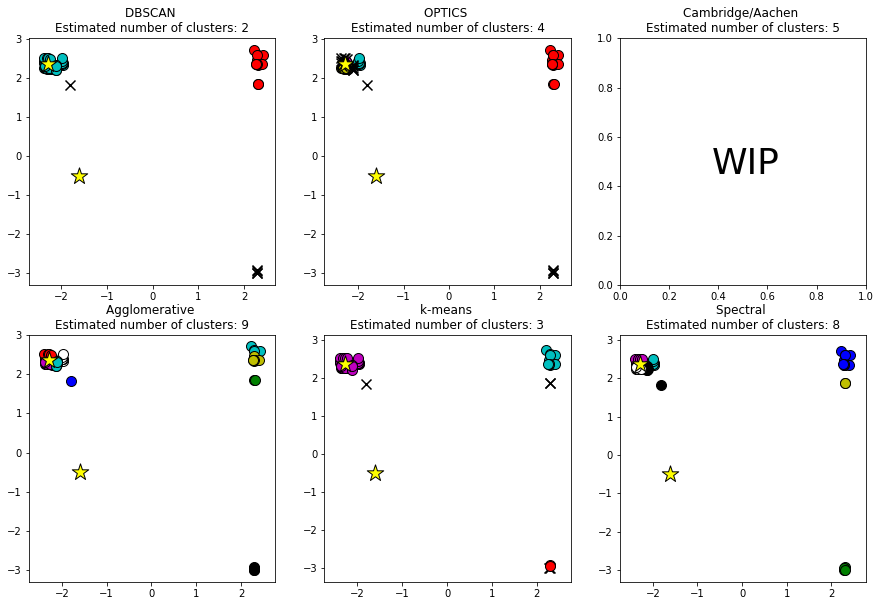

In [296]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(15, 10))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, 0])
ax2 = plt.subplot(G[0, 1])
ax3 = plt.subplot(G[1, 0])
ax4 = plt.subplot(G[1, 1])
ax5 = plt.subplot(G[1, 2])
ax6 = plt.subplot(G[0, 2])

colors = "rcmygbkwc"
color_index = 0

for cluster_index_db in set(dblabels):
    cluster_db = np.dstack(data_test[0][np.where(dblabels==cluster_index_db)])
    if cluster_index_db == -1:
        color_plt = "black"
        marker_plt = 'x'
    else:
        color_plt = colors[color_index]
        marker_plt = 'o'
        color_index +=1
    ax1.scatter(cluster_db[0][0], cluster_db[0][1], color = color_plt, marker=marker_plt, edgecolors='black', s=100)
    
ax1.scatter(gLLP_eta['m50ct1m'][index_test], gLLP_phi['m50ct1m'][index_test], s=300, marker='*', edgecolors='black', color='yellow', zorder=3)
ax1.set_title('DBSCAN \nEstimated number of clusters: %d' % n_clusters_db)

color_index = 0

for cluster_index_op in set(oplabels):
    cluster_op = np.dstack(data_test[0][np.where(oplabels==cluster_index_op)])
    if cluster_index_op == -1:
        color_plt = "black"
        marker_plt = 'x'
    else:
        color_plt = colors[color_index]
        marker_plt = 'o'
        color_index +=1
    ax2.scatter(cluster_op[0][0], cluster_op[0][1], color = color_plt, marker=marker_plt, edgecolors='black', s=100)
    
ax2.scatter(gLLP_eta['m50ct1m'][index_test], gLLP_phi['m50ct1m'][index_test], s=300, marker='*', edgecolors='black', color='yellow', zorder=3)
ax2.set_title('OPTICS \nEstimated number of clusters: %d' % n_clusters_op)

color_index = 0

for cluster_index_ag in set(aglabels):
    cluster_ag = np.dstack(data_test[0][np.where(aglabels==cluster_index_ag)])
    if cluster_index_ag == -1:
        color_plt = "black"
        marker_plt = 'x'
    else:
        color_plt = colors[color_index]
        marker_plt = 'o'
        color_index +=1
    ax3.scatter(cluster_ag[0][0], cluster_ag[0][1], color = color_plt, marker=marker_plt, edgecolors='black', s=100)
    
ax3.scatter(gLLP_eta['m50ct1m'][index_test], gLLP_phi['m50ct1m'][index_test], s=300, marker='*', edgecolors='black', color='yellow', zorder=3)
ax3.set_title('Agglomerative \nEstimated number of clusters: %d' % n_clusters_ag)

color_index = 0

for cluster_index_km in set(kmlabels_prime):
    cluster_km = np.dstack(data_test[0][np.where(kmlabels_prime==cluster_index_km)])
    if cluster_index_km == 0:
        color_plt = "black"
        marker_plt = 'x'
    else:
        color_plt = colors[color_index]
        marker_plt = 'o'
        color_index +=1
    ax4.scatter(cluster_km[0][0], cluster_km[0][1], color = color_plt, marker=marker_plt, edgecolors='black', s=100)
    
    
ax4.scatter(gLLP_eta['m50ct1m'][index_test], gLLP_phi['m50ct1m'][index_test], s=300, marker='*', edgecolors='black', color='yellow', zorder=3)
ax4.set_title('k-means \nEstimated number of clusters: %d' % n_clusters_km_prime)

color_index = 0

for cluster_index_sc in set(sclabels):
    cluster_sc = np.dstack(data_test[0][np.where(sclabels==cluster_index_sc)])
    if cluster_index_sc == -1:
        color_plt = "black"
        marker_plt = 'x'
    else:
        color_plt = colors[color_index]
        marker_plt = 'o'
        color_index +=1
    ax5.scatter(cluster_sc[0][0], cluster_sc[0][1], color = color_plt, marker=marker_plt, edgecolors='black', s=100)
    
ax5.scatter(gLLP_eta['m50ct1m'][index_test], gLLP_phi['m50ct1m'][index_test], s=300, marker='*', edgecolors='black', color='yellow', zorder=3)
ax5.set_title('Spectral \nEstimated number of clusters: %d' % n_clusters_sc)

color_index = 0

for cluster_pseudo in jets_test:
    color_plt = colors[color_index]
    marker_plt = 'o'
    color_index +=1
#     ax6.scatter(cluster_pseudo.eta, cluster_pseudo.phi, color = color_plt, marker=marker_plt, edgecolors='black', s=100)
    
# ax6.scatter(gLLP_eta['m50ct1m'][index_test], gLLP_phi['m50ct1m'][index_test], s=300, marker='*', edgecolors='black', color='yellow', zorder=3)
ax6.text(0.375, 0.45, 'WIP', fontsize=36)
ax6.set_title('Cambridge/Aachen \nEstimated number of clusters: %d' % len(jets_test))
plt.show()

# Clustering Metrics

In [484]:
clustering_files = ['wh_m55ct10m', 'wjetstolnu']

In [485]:
def ang_dist(array1, array2):
    return np.sqrt((array1[0]-array2[0])**2 + (array1[1]-array2[1])**2)

def three_dim_dist(array1, array2):
    return np.sqrt((array1[0]-array2[0])**2 + (array1[1]-array2[1])**2 + (array1[2]-array2[2])**2)

In [491]:
ncsc_pop_cluster = {}
ncsc_noise = {}
pop_dist = {}
# closest_dist = {}
# n_clusters_closest = {}

for species in clustering_files:
    ncsc_pop_cluster[species] = {}
    ncsc_pop_cluster[species]['dbscan'] = []
    ncsc_pop_cluster[species]['optics'] = []
#     ncsc_pop_cluster[species]['kmeans'] = []
    
    ncsc_noise[species] = {}
    ncsc_noise[species]['dbscan'] = []
    ncsc_noise[species]['optics'] = []
#     ncsc_noise[species]['kmeans'] = []
    
#     pop_dist[species] = {}
#     pop_dist[species]['dbscan'] = []
#     pop_dist[species]['optics'] = []
#     pop_dist[species]['kmeans'] = []
    
    for event_segments in range(len(csc_z[species][nCsc[species]>30])):
#         eta_segments = csc_eta[species][nCsc[species]>80][event_segments]
#         phi_segments = csc_phi[species][nCsc[species]>80][event_segments]
#         gLLP_eta_segments = gLLP_eta[species][nCsc[species]>80][event_segments]
#         gLLP_phi_segments = gLLP_phi[species][nCsc[species]>80][event_segments]
        x_segments = csc_x[species][nCsc[species]>30][event_segments]
        y_segments = csc_y[species][nCsc[species]>30][event_segments]
        z_segments = csc_z[species][nCsc[species]>30][event_segments]
        
#         gLLP_x_segments = gLLP_eta[species][nCsc[species]>30][event_segments]
#         gLLP_y_segments = gLLP_eta[species][nCsc[species]>30][event_segments]
#         gLLP_z_segments = gLLP_eta[species][nCsc[species]>30][event_segments]
        
        data_segments = np.dstack((x_segments, y_segments, z_segments))[0]
#         print(data_segments)
        # DBSCAN 
#         data_segments = np.dstack((eta_segments, phi_segments))[0]
        db = skc.DBSCAN(eps=200, min_samples=10).fit(data_segments)
        dblabels = db.labels_[db.labels_!=-1]
        unique_db, counts_db = np.unique(dblabels, return_counts=True)
        db_dict = dict(zip(counts_db, unique_db))
#         print(dblabels)
        # Backwards: noise/pop_cluster
        if len(dblabels) == 0:
            ncsc_noise[species]['dbscan'].append(len(db.labels_))
            ncsc_pop_cluster[species]['dbscan'].append(0)
#             pop_dist[species]['dbscan'].append(-999)
        else:
            db_pop_index = db_dict[np.max(counts_db)]
            ncsc_noise[species]['dbscan'].append(list(db.labels_).count(-1))
            ncsc_pop_cluster[species]['dbscan'].append(np.max(counts_db))
            
#             db_centroids = NearestCentroid().fit(data_segments, db.labels_).centroids_
#             pop_dist[species]['dbscan'].append(np.absolute(ang_dist(db_centroids[db_pop_index])-ang_dist([gLLP_eta_segments[0], gLLP_phi_segments[0]])))
#             pop_dist[species]['dbscan'].append(ang_dist([np.mean(eta_segments[db.labels_== db_pop_index]), np.mean(phi_segments[db.labels_== db_pop_index])], [gLLP_eta_segments[0], gLLP_phi_segments[0]]))
        
#             pop_dist[species]['dbscan'].append(three_dim_dist([np.mean(x_segments[db.labels_== db_pop_index]), np.mean(y_segments[db.labels_== db_pop_index]), np.mean(z_segments[db.labels_== db_pop_index])], [gLLP_x_segments[0], gLLP_y_segments[0], gLLP_z_segments[0]]))
        
#         try:
#             db_centroids = NearestCentroid().fit(data_segments, dblabels).centroids_
# #             pop_dist[species]['dbscan'].append(np.absolute(ang_dist(db_centroids[db_pop_index])-ang_dist([gLLP_eta_segments[0], gLLP_phi_segments[0]])))
#             pop_dist[species]['dbscan'].append(ang_dist(db_centroids[db_pop_index], [gLLP_eta_segments[0], gLLP_phi_segments[0]]))
        
#         except ValueError:
#             pop_dist[species]['dbscan'].append(999)
            
#         db_centroids = NearestCentroid().fit(data_segments, dblabels).centroids_
        
        
        
        # OPTICS
        optics = skc.OPTICS(min_samples=10, xi=.05).fit(data_segments)
        oplabels = optics.labels_[optics.labels_!=-1]
        unique_op, counts_op = np.unique(oplabels, return_counts=True)
        op_dict = dict(zip(counts_op, unique_op))
        
        if len(oplabels) == 0:
            ncsc_noise[species]['optics'].append(len(optics.labels_))
            ncsc_pop_cluster[species]['optics'].append(0)
#             pop_dist[species]['optics'].append(-999)
        else:
            op_pop_index = op_dict[np.max(counts_op)]
            ncsc_noise[species]['optics'].append(list(optics.labels_).count(-1))
            ncsc_pop_cluster[species]['optics'].append(np.max(counts_op))
            
#             op_centroids = NearestCentroid().fit(data_segments, optics.labels_).centroids_
            
#             pop_dist[species]['optics'].append(ang_dist([np.mean(eta_segments[optics.labels_== op_pop_index]), np.mean(phi_segments[optics.labels_== op_pop_index])], [gLLP_eta_segments[0], gLLP_phi_segments[0]]))
#             pop_dist[species]['optics'].append(three_dim_dist([np.mean(x_segments[optics.labels_== op_pop_index]), np.mean(y_segments[optics.labels_== op_pop_index]), np.mean(z_segments[optics.labels_== op_pop_index])], [gLLP_x_segments[0], gLLP_y_segments[0], gLLP_z_segments[0]]))

#         try:
#             op_centroids = NearestCentroid().fit(data_segments, oplabels).centroids_
            
#             pop_dist[species]['optics'].append(ang_dist(op_centroids[op_pop_index], [gLLP_eta_segments[0], gLLP_phi_segments[0]]))
            
#         except ValueError:
#             pop_dist[species]['optics'].append(999)
        
        
#         # k-means
#         centroids_km,centroid_constituents_km = kmeans(data_segments,25)
#         kmlabels = getLabels(data_segments, centroids_km, 25)
#         centroids_constituents_prime = centroid_constituents_km[1:]
#         km_pop_index = np.where(centroids_constituents_prime == np.max(centroids_constituents_prime))[0][0]+1
#         ncsc_noise[species]['kmeans'].append(list(kmlabels).count(0))
#         ncsc_pop_cluster[species]['kmeans'].append(np.max(centroids_constituents_prime))
#         pop_dist[species]['kmeans'].append(ang_dist(centroids_km[km_pop_index], [gLLP_eta_segments[0], gLLP_phi_segments[0]]))

    
    print(species + ': ' +str(datetime.datetime.now(pytz.timezone('US/Pacific'))))

KeyboardInterrupt: 

## Supervised Metrics

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_pop_dist


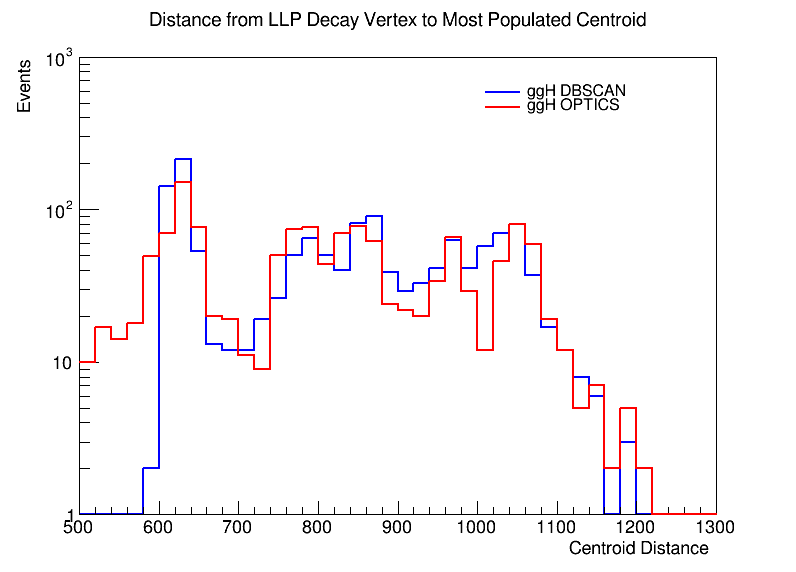

In [470]:

c_pop_dist = rt.TCanvas('c_pop_dist','c_pop_dist', 800, 600)
h= {}
h['sig_dist_dbscan'] = create_TH1D(pop_dist['m50ct1m']['dbscan'], axis_title=['sig_dist_dbscan', 'Events'], name='sig_dist_dbscan', binning=[100,0,2000])
h['sig_dist_dbscan'].SetLineColor(4)
h['sig_dist_dbscan'].SetLineStyle(1)

h['sig_dist_optics'] = create_TH1D(pop_dist['m50ct1m']['optics'], axis_title=['sig_dist_optics', 'Events'], name='sig_dist_optics', binning=[100,0,2000])
h['sig_dist_optics'].SetLineColor(2)
h['sig_dist_optics'].SetLineStyle(1)

# h['sig_dist_kmeans'] = create_TH1D(pop_dist['m50ct1m']['kmeans'], axis_title=['sig_dist_kmeans', 'Events'], name='sig_dist_kmeans', binning=[100,-5,5])
# h['sig_dist_kmeans'].SetLineColor(1)
# h['sig_dist_kmeans'].SetLineStyle(1)


h['bkg_dist_dbscan'] = create_TH1D(pop_dist['qcd']['dbscan'], axis_title=['bkg_dist_dbscan', 'Events'], name='bkg_dist_dbscan', binning=[100,0,2000])
h['bkg_dist_dbscan'].SetLineColor(2)
h['bkg_dist_dbscan'].SetLineStyle(1)

h['bkg_dist_optics'] = create_TH1D(pop_dist['qcd']['optics'], axis_title=['bkg_dist_optics', 'Events'], name='bkg_dist_optics', binning=[100,0,2000])
h['bkg_dist_optics'].SetLineColor(2)
h['bkg_dist_optics'].SetLineStyle(2)

# h['bkg_dist_kmeans'] = create_TH1D(pop_dist['qcd']['kmeans'], axis_title=['bkg_dist_kmeans', 'Events'], name='bkg_dist_kmeans', binning=[100,-5,5])
# h['bkg_dist_kmeans'].SetLineColor(2)
# h['bkg_dist_kmeans'].SetLineStyle(3)

c_pop_dist.SetLogy()

h['sig_dist_dbscan'].SetLineWidth(2)
h['sig_dist_optics'].SetLineWidth(2)
# h['sig_dist_kmeans'].SetLineWidth(2)
h['bkg_dist_dbscan'].SetLineWidth(2)
h['bkg_dist_optics'].SetLineWidth(2)
# h['bkg_dist_kmeans'].SetLineWidth(2)

h['sig_dist_dbscan'].GetYaxis().SetRangeUser(1,10**3)
h['sig_dist_dbscan'].GetXaxis().SetRangeUser(500,1300)


h['sig_dist_dbscan'].SetStats(0)
h['sig_dist_dbscan'].SetTitle("Distance from LLP Decay Vertex to Most Populated Centroid")
h['sig_dist_dbscan'].SetXTitle("Centroid Distance")


h['sig_dist_dbscan'].Draw('histo')
h['sig_dist_optics'].Draw('histo+same')
# h['sig_dist_kmeans'].Draw('histo+same')
# h['bkg_dist_dbscan'].Draw('histo+same')
# h['bkg_dist_optics'].Draw('histo+same')
# h['bkg_dist_kmeans'].Draw('histo+same')



# legend = rt.TLegend(0.48,0.70,0.87,0.87);
legend = rt.TLegend(0.6,0.80,0.85,0.85);
legend.SetTextSize(0.03);
legend.SetBorderSize(0);
legend.AddEntry( h['sig_dist_dbscan'], "ggH DBSCAN" , "L");
legend.AddEntry( h['sig_dist_optics'], "ggH OPTICS" , "L");
# legend.AddEntry( h['sig_dist_kmeans'], "ggH k-means" , "L");
# legend.AddEntry( h['bkg_dist_dbscan'], "QCD DBSCAN" , "L");
# legend.AddEntry( h['bkg_dist_optics'], "QCD OPTICS" , "L");
# legend.AddEntry( h['bkg_dist_kmeans'], "QCD k-means" , "L");

legend.Draw();

c_pop_dist.Draw()

# c.SaveAs("ncsc_inclusive_mc_zeroBias.pdf")
# c.SaveAs("ncsc_inclusive_mc_zeroBias.C")

## Unsupervised Metrics

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_noise


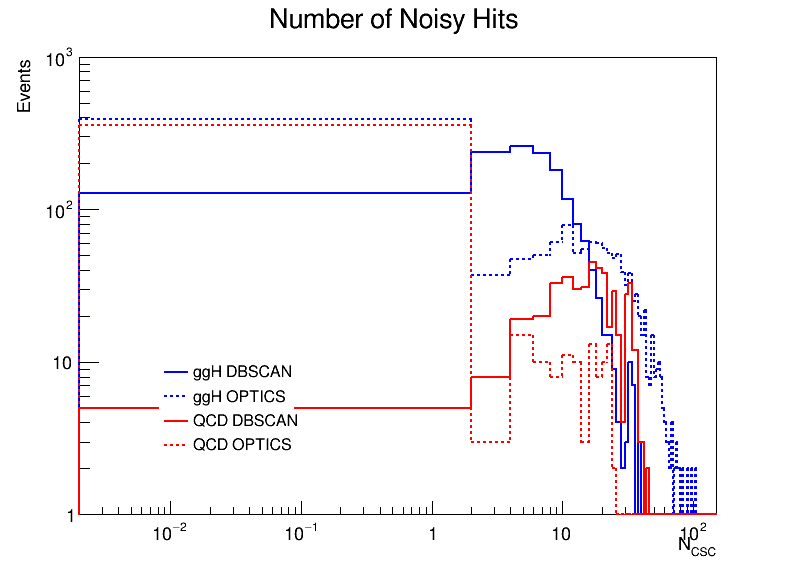

In [472]:
c_noise = rt.TCanvas('c_noise','c_noise', 800, 600)

h['sig_noise_dbscan'] = create_TH1D(ncsc_noise['m50ct1m']['dbscan'], axis_title=['sig_noise_dbscan', 'Events'], name='sig_noise_dbscan', binning=[100,0,200])
h['sig_noise_dbscan'].SetLineColor(4)
h['sig_noise_dbscan'].SetLineStyle(1)

h['sig_noise_optics'] = create_TH1D(ncsc_noise['m50ct1m']['optics'], axis_title=['sig_noise_optics', 'Events'], name='sig_noise_optics', binning=[100,0,200])
h['sig_noise_optics'].SetLineColor(4)
h['sig_noise_optics'].SetLineStyle(2)

# h['sig_noise_kmeans'] = create_TH1D(ncsc_noise['m50ct1m']['kmeans'], axis_title=['sig_noise_kmeans', 'Events'], name='sig_noise_kmeans', binning=[100,0,200])
# h['sig_noise_kmeans'].SetLineColor(4)
# h['sig_noise_kmeans'].SetLineStyle(3)


h['bkg_noise_dbscan'] = create_TH1D(ncsc_noise['qcd']['dbscan'], axis_title=['bkg_noise_dbscan', 'Events'], name='bkg_noise_dbscan', binning=[100,0,200])
h['bkg_noise_dbscan'].SetLineColor(2)
h['bkg_noise_dbscan'].SetLineStyle(1)

h['bkg_noise_optics'] = create_TH1D(ncsc_noise['qcd']['optics'], axis_title=['bkg_noise_optics', 'Events'], name='bkg_noise_optics', binning=[100,0,200])
h['bkg_noise_optics'].SetLineColor(2)
h['bkg_noise_optics'].SetLineStyle(2)

# h['bkg_noise_kmeans'] = create_TH1D(ncsc_noise['qcd']['kmeans'], axis_title=['bkg_noise_kmeans', 'Events'], name='bkg_noise_kmeans', binning=[100,0,200])
# h['bkg_noise_kmeans'].SetLineColor(2)
# h['bkg_noise_kmeans'].SetLineStyle(3)

c_noise.SetLogy()
c_noise.SetLogx()

h['sig_noise_dbscan'].SetLineWidth(2)
h['sig_noise_optics'].SetLineWidth(2)
# h['sig_noise_kmeans'].SetLineWidth(2)
h['bkg_noise_dbscan'].SetLineWidth(2)
h['bkg_noise_optics'].SetLineWidth(2)
# h['bkg_noise_kmeans'].SetLineWidth(2)

h['sig_noise_dbscan'].GetYaxis().SetRangeUser(1,10**3)
h['sig_noise_dbscan'].GetXaxis().SetRangeUser(0,150)


h['sig_noise_dbscan'].SetStats(0)
h['sig_noise_dbscan'].SetTitle("Number of Noisy Hits")
h['sig_noise_dbscan'].SetXTitle("N_{CSC}")


h['sig_noise_dbscan'].Draw('histo')
h['sig_noise_optics'].Draw('histo+same')
# h['sig_noise_kmeans'].Draw('histo+same')
h['bkg_noise_dbscan'].Draw('histo+same')
h['bkg_noise_optics'].Draw('histo+same')
# h['bkg_noise_kmeans'].Draw('histo+same')



# legend = rt.TLegend(0.48,0.70,0.87,0.87);
legend = rt.TLegend(0.2,0.20,0.37,0.37);
legend.SetTextSize(0.03);
legend.SetBorderSize(0);
legend.AddEntry( h['sig_noise_dbscan'], "ggH DBSCAN" , "L");
legend.AddEntry( h['sig_noise_optics'], "ggH OPTICS" , "L");
# legend.AddEntry( h['sig_noise_kmeans'], "ggH k-means" , "L");
legend.AddEntry( h['bkg_noise_dbscan'], "QCD DBSCAN" , "L");
legend.AddEntry( h['bkg_noise_optics'], "QCD OPTICS" , "L");
# legend.AddEntry( h['bkg_noise_kmeans'], "QCD k-means" , "L");

legend.Draw();

c_noise.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_pop


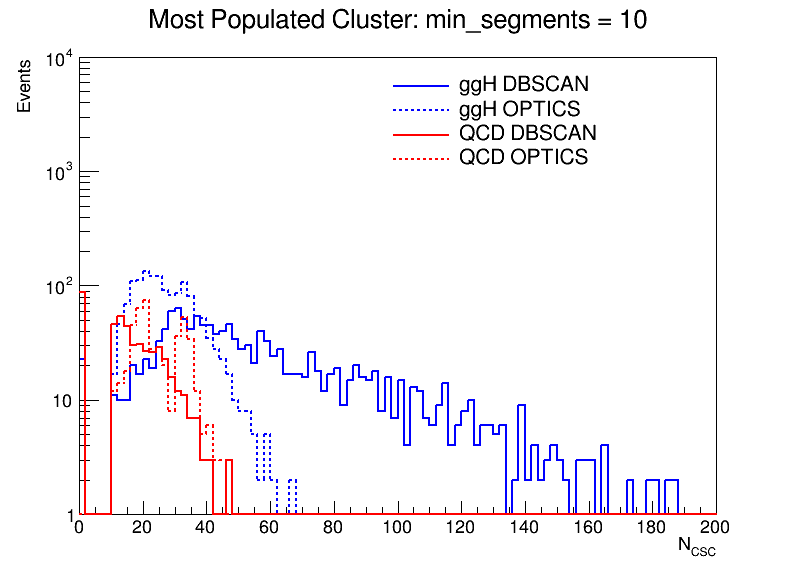

In [473]:
c_pop = rt.TCanvas('c_pop','c_pop', 800, 600)

h['sig_pop_dbscan'] = create_TH1D(ncsc_pop_cluster['m50ct1m']['dbscan'], axis_title=['sig_pop_dbscan', 'Events'], name='sig_pop_dbscan', binning=[100,0,200])
h['sig_pop_dbscan'].SetLineColor(4)
h['sig_pop_dbscan'].SetLineStyle(1)

h['sig_pop_optics'] = create_TH1D(ncsc_pop_cluster['m50ct1m']['optics'], axis_title=['sig_pop_optics', 'Events'], name='sig_pop_optics', binning=[100,0,200])
h['sig_pop_optics'].SetLineColor(4)
h['sig_pop_optics'].SetLineStyle(2)

# h['sig_pop_kmeans'] = create_TH1D(ncsc_pop_cluster['m50ct1m']['kmeans'], axis_title=['sig_pop_kmeans', 'Events'], name='sig_pop_kmeans', binning=[100,0,200])
# h['sig_pop_kmeans'].SetLineColor(4)
# h['sig_pop_kmeans'].SetLineStyle(3)


h['bkg_pop_dbscan'] = create_TH1D(ncsc_pop_cluster['qcd']['dbscan'], axis_title=['bkg_pop_dbscan', 'Events'], name='bkg_pop_dbscan', binning=[100,0,200])
h['bkg_pop_dbscan'].SetLineColor(2)
h['bkg_pop_dbscan'].SetLineStyle(1)

h['bkg_pop_optics'] = create_TH1D(ncsc_pop_cluster['qcd']['optics'], axis_title=['bkg_pop_optics', 'Events'], name='bkg_pop_optics', binning=[100,0,200])
h['bkg_pop_optics'].SetLineColor(2)
h['bkg_pop_optics'].SetLineStyle(2)

# h['bkg_pop_kmeans'] = create_TH1D(ncsc_pop_cluster['qcd']['kmeans'], axis_title=['bkg_pop_kmeans', 'Events'], name='bkg_pop_kmeans', binning=[100,0,200])
# h['bkg_pop_kmeans'].SetLineColor(2)
# h['bkg_pop_kmeans'].SetLineStyle(3)

c_pop.SetLogy()

h['sig_pop_dbscan'].SetLineWidth(2)
h['sig_pop_optics'].SetLineWidth(2)
# h['sig_pop_kmeans'].SetLineWidth(2)
h['bkg_pop_dbscan'].SetLineWidth(2)
h['bkg_pop_optics'].SetLineWidth(2)
# h['bkg_pop_kmeans'].SetLineWidth(2)

h['sig_pop_dbscan'].GetYaxis().SetRangeUser(1,10**4)
h['sig_pop_dbscan'].GetXaxis().SetRangeUser(0,200)


h['sig_pop_dbscan'].SetStats(0)
h['sig_pop_dbscan'].SetTitle("Most Populated Cluster: min_segments = 10")
h['sig_pop_dbscan'].SetXTitle("N_{CSC}")


h['sig_pop_dbscan'].Draw('histo')
h['sig_pop_optics'].Draw('histo+same')
# h['sig_pop_kmeans'].Draw('histo+same')
h['bkg_pop_dbscan'].Draw('histo+same')
h['bkg_pop_optics'].Draw('histo+same')
# h['bkg_pop_kmeans'].Draw('histo+same')



legend = rt.TLegend(0.48,0.70,0.87,0.87);
# legend = rt.TLegend(0.6,0.60,0.6,0.6);
legend.SetTextSize(0.04);
legend.SetBorderSize(0);
legend.AddEntry( h['sig_pop_dbscan'], "ggH DBSCAN" , "L");
legend.AddEntry( h['sig_pop_optics'], "ggH OPTICS" , "L");
# legend.AddEntry( h['sig_pop_kmeans'], "ggH k-means" , "L");
legend.AddEntry( h['bkg_pop_dbscan'], "QCD DBSCAN" , "L");
legend.AddEntry( h['bkg_pop_optics'], "QCD OPTICS" , "L");
# legend.AddEntry( h['bkg_pop_kmeans'], "QCD k-means" , "L");

legend.Draw();

c_pop.Draw()